## Setting up:

In [1]:
import os, sys
sys.path.append(os.path.join(os.getcwd(), '../../')) # Add root of repo to import MBM

import pandas as pd
import os
import warnings
import massbalancemachine as mbm
import pyproj
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import geopandas as gpd
import logging
import glob
from cmcrameri import cm
from oggm import utils

from scripts.helpers import *
from scripts.iceland_preprocess import *
from scripts.config_ICE import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

cfg = mbm.IcelandConfig(dataPath='/home/mburlet/scratch/data/DATA_MB/WGMS/Iceland/')

# Module logger
log = logging.getLogger('.'.join(__name__.split('.')[:-1]))

In [2]:
seed_all(cfg.seed)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)

cmap = cm.devon

# For bars and lines:
color_diff_xgb = '#4d4d4d'

colors = get_cmap_hex(cm.batlow, 10)
color_1 = colors[0]
color_2 = '#c51b7d'

### Load all stake csv files into 1 df

###### The data used in this code comes from the data scraping done in the 1.0 Iceland-data-acquisition notebook in June 2025, only winter and annual measurements are used. Code might have to be adjusted if new data is added to https://joklavefsja.vedur.is/

In [3]:
all_files = glob.glob(os.path.join(cfg.dataPath + path_PMB_WGMS_raw, "*.csv"))

# Initialize empty list to store dataframes
dfs = []

# Read each CSV file into a dataframe and append to list
for file in all_files:
    df = pd.read_csv(file)
    dfs.append(df)

# Concatenate all dataframes into one
combined_df = pd.concat(dfs, ignore_index=True)

# Print info
print(f"Combined {len(all_files)} CSV files into one dataframe with {len(combined_df)} rows")

# Add data modification column to keep track of mannual changes
combined_df['DATA_MODIFICATION'] = ''


display(combined_df.head(2))


Combined 543 CSV files into one dataframe with 3783 rows


,ba_floating_date,ba_stratigraphic,bs_floating_date,bs_stratigraphic,bw_floating_date,bw_stratigraphic,d1,d2,d3,ds,...,lon,nswe_fall,rhos,rhow,snow_melt_fall,stake,swes,swew,yr,DATA_MODIFICATION
0,NaN,NaN,NaN,NaN,1.224,1.224,NaN,1997-06-10,NaN,NaN,...,-17.283667,NaN,NaN,450.0,NaN,GL11,NaN,1.224,1997,
1,NaN,NaN,-0.531661,-0.741661,NaN,NaN,2007-10-10,2008-06-04,2008-09-29,NaN,...,-17.286686,0.21,NaN,NaN,NaN,Gh03b,NaN,NaN,2008,


###### Split into annual and winter rows

In [4]:
df_stakes_split = split_stake_measurements(combined_df)

# Convert date columns to string in 'YYYYMMDD' format
df_stakes_split['TO_DATE'] = pd.to_datetime(df_stakes_split['TO_DATE']).dt.strftime('%Y%m%d')
df_stakes_split['FROM_DATE'] = pd.to_datetime(df_stakes_split['FROM_DATE']).dt.strftime('%Y%m%d')

display(df_stakes_split)

,elevation,lat,lon,stake,DATA_MODIFICATION,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,YEAR
0,1744.39,64.555705,-17.410172,Gjal28,,20060925,20071010,1.785833,annual,2007.0
1,1594.20,64.529965,-17.007155,D09,,NaN,19930928,3.375500,annual,1993.0
2,1591.50,64.530070,-17.008139,D09,,19930928,19940916,1.794500,annual,1994.0
3,1590.00,64.530167,-17.009000,D09,,NaN,19961001,1.370000,annual,1996.0
4,1586.90,64.530737,-17.009282,D09,,19961001,19970825,0.430000,annual,1997.0
...,...,...,...,...,...,...,...,...,...,...
6593,1127.80,64.714302,-19.073915,hsv11,,20141010,20150503,3.230000,winter,2015.0
6594,1125.70,64.714302,-19.073915,hsv11,,20151008,20160503,1.650000,winter,2016.0
6595,1512.00,64.423584,-17.248647,SKTH,,19990924,20000611,2.766000,winter,2000.0
6596,1542.49,64.437501,-17.399826,Gh15a,,NaN,20070605,2.321198,winter,2007.0


#### Date Fixes

###### Fix NaN dates by adding hydrological year dates. (It would be nicer if this code also checked if there was a previous year of the same stake with a date and then takes that date instead of hydr. year)

In [5]:
display(df_stakes_split[df_stakes_split['FROM_DATE'].isna()])
display(df_stakes_split[df_stakes_split['TO_DATE'].isna()])
display(df_stakes_split[df_stakes_split['YEAR'].isna()])

# Change NaN year values to the year of the TO_DATE
df_stakes_split.loc[df_stakes_split['YEAR'].isna(), 'YEAR'] = df_stakes_split.loc[df_stakes_split['YEAR'].isna(), 'TO_DATE'].astype(str).str[:4].astype(float)

# Data modification column update
date_nan_mask = df_stakes_split['FROM_DATE'].isna() | df_stakes_split['TO_DATE'].isna()
df_stakes_split.loc[date_nan_mask, 'DATA_MODIFICATION'] = 'Dates filled in according to hydrological year'
# Set FROM_DATE from NaN to 01 Oct of previous year
df_stakes_split.loc[df_stakes_split['FROM_DATE'].isna(), 'FROM_DATE'] = (
    (df_stakes_split.loc[df_stakes_split['FROM_DATE'].isna(), 'YEAR'].astype(int) - 1).astype(str) + '1001'
)
# Set TO_DATE from NaN to 30 Sept of the year (as only annual rows have NaN, no need for period distinction)
df_stakes_split.loc[df_stakes_split['TO_DATE'].isna(), 'TO_DATE'] = (
    df_stakes_split.loc[df_stakes_split['TO_DATE'].isna(), 'YEAR'].astype(int).astype(str) + '0930'
)


,elevation,lat,lon,stake,DATA_MODIFICATION,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,YEAR
1,1594.200000,64.529965,-17.007155,D09,,NaN,19930928,3.375500,annual,1993.0
3,1590.000000,64.530167,-17.009000,D09,,NaN,19961001,1.370000,annual,1996.0
7,1572.910000,64.530269,-17.009506,D09,,NaN,20051003,0.595000,annual,2005.0
26,1537.700000,64.443660,-17.308348,G02a,,NaN,19940830,1.500000,annual,1994.0
54,1175.330444,64.700000,-20.050000,L15,,NaN,19971012,0.282500,annual,1997.0
...,...,...,...,...,...,...,...,...,...,...
6482,865.100000,64.788615,-16.733066,D02,,NaN,19930507,0.850000,winter,1993.0
6483,1012.300000,64.792462,-16.764544,D02,,NaN,19950501,0.700000,winter,1995.0
6568,1364.900000,64.370383,-17.758666,Tu13,,NaN,19860503,1.739000,winter,1986.0
6596,1542.490000,64.437501,-17.399826,Gh15a,,NaN,20070605,2.321198,winter,2007.0


,elevation,lat,lon,stake,DATA_MODIFICATION,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,YEAR
100,743.00,64.530701,-20.432091,L02,,20131119,NaN,-4.9710,annual,2014.0
1046,1522.00,64.378917,-16.081383,BB0,,19980926,NaN,1.8580,annual,1999.0
1208,761.04,64.319255,-18.108742,T01,,20221027,NaN,-6.6000,annual,2023.0
1405,173.85,64.105975,-16.375490,Br2,,20201010,NaN,-9.9300,annual,2021.0
1703,839.45,64.797799,-16.832915,D01,,NaN,NaN,-4.9000,annual,2023.0
1778,1197.60,64.740622,-17.051846,D10,,19961001,NaN,-1.2005,annual,1997.0
1936,844.00,64.575920,-20.032940,L12,,20070925,NaN,-3.8690,annual,2008.0
2843,364.04,64.140565,-16.400018,Br3,,20201010,NaN,-7.3500,annual,2021.0


,elevation,lat,lon,stake,DATA_MODIFICATION,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,YEAR
3210,1670.00,64.542001,-17.283667,GL11,,NaN,19970610,1.224,winter,NaN
3211,1640.00,64.449993,-17.450001,GL7a,,NaN,19970825,0.930,winter,NaN
3215,1589.30,64.530834,-17.007278,D09,,19940916,19950501,2.170,winter,NaN
3239,1869.84,64.650388,-17.386972,BB08,,NaN,20230531,1.840,winter,NaN
3242,1892.00,64.656667,-17.433333,Bafk04,,NaN,20150610,2.390,winter,NaN
...,...,...,...,...,...,...,...,...,...,...
6417,1887.51,64.640160,-17.446367,Barc,,NaN,20170608,2.970,winter,NaN
6420,1900.20,64.640148,-17.446338,Barc,,20201010,20210608,2.115,winter,NaN
6431,1047.90,64.790063,-18.595688,hsa11,,19950915,19960512,1.020,winter,NaN
6535,1444.50,64.869136,-18.867241,hn15,,19910912,19920514,3.690,winter,NaN


###### Check for problematic date ranges

In [6]:
annual_inconsistent, winter_inconsistent = check_period_consistency(df_stakes_split)


# Display the inconsistent records
if len(annual_inconsistent) > 0:
    print("\nInconsistent annual periods:")
    display(annual_inconsistent)

if len(winter_inconsistent) > 0:
    print("\nInconsistent winter periods:")
    display(winter_inconsistent)

# Only index 5084 is unreasonabl (-2), probably wrong FROM_DATE year, change to year - 1
df_stakes_split.loc[df_stakes_split['stake']=='GL10a', 'FROM_DATE'] = '19960825'
df_stakes_split.loc[df_stakes_split['stake']=='GL10a', 'DATA_MODIFICATION'] = 'FROM_DATE year corrected from 1997 to 1996'

Annual periods: 0 out of 3210 (0.0%) are inconsistent
Winter periods: 13 out of 3388 (0.4%) are inconsistent

Inconsistent winter periods:


,elevation,lat,lon,stake,DATA_MODIFICATION,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,YEAR,FROM_DATE_DT,TO_DATE_DT,MONTH_DIFF
3211,1640.0,64.449993,-17.450001,GL7a,Dates filled in according to hydrological year,19961001,19970825,0.9300,winter,1997.0,1996-10-01,1997-08-25,10
4239,1411.0,64.416605,-17.336742,Bor,,19960830,19970611,2.0000,winter,1997.0,1996-08-30,1997-06-11,10
4240,1380.0,64.415715,-17.336125,Bor,,19970826,19980607,1.5915,winter,1998.0,1997-08-26,1998-06-07,10
4241,1385.0,64.415667,-17.336017,Bor,,19980825,19990606,2.6920,winter,1999.0,1998-08-25,1999-06-06,10
4525,1970.0,64.639364,-17.523302,K06,,19970825,19980615,1.9165,winter,1998.0,1997-08-25,1998-06-15,10
4526,1970.0,64.639217,-17.523233,K06,,19980826,19990610,2.1760,winter,1999.0,1998-08-26,1999-06-10,10
4552,1825.0,63.996503,-16.650666,Oer01,Dates filled in according to hydrological year,19931001,19940829,7.7800,winter,1994.0,1993-10-01,1994-08-29,10
4553,1825.0,63.996503,-16.650666,Oer01,,19940829,19950611,5.7500,winter,1995.0,1994-08-29,1995-06-11,10
5261,1770.0,64.566674,-17.466664,GL10,Dates filled in according to hydrological year,19961001,19970825,1.2000,winter,1997.0,1996-10-01,1997-08-25,10
5536,1635.0,64.583004,-17.265992,GL10a,,19970825,19970610,1.4985,winter,1997.0,1997-08-25,1997-06-10,-2


###### Rename Columns and general data cleaning, we can skip the close stake removal, as seen form the leaflet map online, the stakes are spaced out.

In [7]:
df_stakes_renamed = df_stakes_split.rename(columns={
    'lat': 'POINT_LAT', 
    'lon': 'POINT_LON',
    'elevation': 'POINT_ELEVATION',
    'stake': 'ID',
})

In [8]:
# NaN check
display(df_stakes_renamed[df_stakes_renamed.isna().any(axis=1)])

# Remove all rows with any NaN values
df_stakes_renamed = df_stakes_renamed.dropna()

# Confirm removal - this should show 0 rows if all NaNs were removed
print(f"Rows with NaN values after removal: {len(df_stakes_renamed[df_stakes_renamed.isna().any(axis=1)])}")

,POINT_ELEVATION,POINT_LAT,POINT_LON,ID,DATA_MODIFICATION,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,YEAR
266,NaN,64.662707,-18.954942,blt8,,20231024,20241106,-3.79,annual,2024.0
741,NaN,64.836450,-18.871219,hn17,,20231025,20241106,2.23,annual,2024.0
953,NaN,64.934272,-18.846087,hn12,,20231025,20241104,-1.06,annual,2024.0
1041,NaN,64.749711,-19.000955,hsv15,,20231024,20241106,1.37,annual,2024.0
1245,NaN,64.921358,-18.834673,hn13,,20231025,20241104,-1.24,annual,2024.0
1516,NaN,64.687726,-18.954530,blt11,,20231024,20241106,-1.70,annual,2024.0
1685,NaN,64.838974,-18.708493,hsa15,,20231024,20241104,1.23,annual,2024.0
1775,NaN,64.783235,-18.833478,hsa16,,20231024,20241106,1.79,annual,2024.0
1816,NaN,64.957680,-18.860046,hn11,,20231025,20241104,-2.60,annual,2024.0
2123,NaN,64.722491,-19.057862,hsv13,,20231024,20241106,-0.99,annual,2024.0


Rows with NaN values after removal: 0


##### Find RGIId

In [ ]:
# Load glacier outlines
rgi_file = utils.get_rgi_region_file(region="06", version="6")
glacier_outline = gpd.read_file(rgi_file)

# Add RGI IDs through intersection
df_stakes_renamed_rgiid = mbm.data_processing.utils.get_rgi(data=df_stakes_renamed,
                                           glacier_outlines=glacier_outline)

display(df_stakes_renamed_rgiid[df_stakes_renamed_rgiid['RGIId'].isna()])
# Remove (nine) stakes without RGIId, as they wont have OGGM data anyways
df_stakes_renamed_rgiid = df_stakes_renamed_rgiid.dropna(subset=['RGIId'])

,POINT_ELEVATION,POINT_LAT,POINT_LON,ID,DATA_MODIFICATION,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,YEAR,RGIId
1549,490.0,64.492780,-20.43633,L01,,19971012,19980916,-7.0300,annual,1998.0,NaN
1550,505.0,64.493820,-20.43648,L01,,19980916,19990928,-4.9500,annual,1999.0,NaN
1551,490.0,64.493430,-20.43622,L01,,19990928,20001004,-5.4825,annual,2000.0,NaN
1552,485.0,64.493820,-20.43647,L01,,20001004,20011005,-6.3615,annual,2001.0,NaN
4842,490.0,64.492780,-20.43633,L01,,19971012,19980417,0.2900,winter,1998.0,NaN
4843,505.0,64.493820,-20.43648,L01,,19980916,19990422,1.6690,winter,1999.0,NaN
4844,490.0,64.493430,-20.43622,L01,,19990928,20000427,1.3200,winter,2000.0,NaN
4845,485.0,64.493820,-20.43647,L01,,20001004,20010419,0.8845,winter,2001.0,NaN
6333,715.0,64.776661,-16.05650,B08,,19940915,19950503,0.5400,winter,1995.0,NaN


#### Add OGGM data

In [11]:
# initialize OGGM glacier directories
gdirs, rgidf = initialize_oggm_glacier_directories(
    working_dir= cfg.dataPath + path_OGGM,
    rgi_region="06", #06 iceland
    rgi_version="6",
    base_url=
    "https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5_w_data/",
    log_level='WARNING',
    task_list=None,
)


unique_rgis = df_stakes_renamed_rgiid['RGIId'].unique()

run = True
if run:
    export_oggm_grids(gdirs, subset_rgis=unique_rgis, output_path=cfg.dataPath + path_OGGM_xrgrids)

## Around 10% of all the measurements have no hugonnet_dhdt data, so I removed the entire variable from merge_pmb_with_oggm_data()
df_stakes_topo = merge_pmb_with_oggm_data(df_pmb=df_stakes_renamed_rgiid,
                                       gdirs=gdirs,
                                       rgi_region="06", #06 iceland
                                       rgi_version="6")
                                       


2025-06-10 20:18:11: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-06-10 20:18:11: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-06-10 20:18:11: oggm.cfg: Multiprocessing: using all available processors (N=12)
2025-06-10 20:18:12: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2025-06-10 20:18:12: oggm.cfg: Multiprocessing switched ON after user settings.
2025-06-10 20:18:12: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2025-06-10 20:18:14: oggm.workflow: init_glacier_directories from prepro level 3 on 568 glaciers.
2025-06-10 20:18:14: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 568 glaciers
2025-06-10 20:18:19: oggm.workflow: Execute entity tasks [gridded_attributes] on 568 glaciers


###### Get Glacier names from RGIId

In [27]:
# Create a dictionary mapping from RGIId to glacier name
rgi_to_name_dict = dict(zip(rgidf.RGIId, rgidf.Name))
df_stakes_topo['GLACIER'] = df_stakes_topo['RGIId'].map(rgi_to_name_dict)


display(df_stakes_topo[df_stakes_topo['GLACIER'].isna()])


,POINT_ELEVATION,POINT_LAT,POINT_LON,ID,DATA_MODIFICATION,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,YEAR,RGIId,aspect,slope,topo,consensus_ice_thickness,millan_v,within_glacier_shape,GLACIER
54,1175.330444,64.700000,-20.050000,L15,Dates filled in according to hydrological year,19961001,19971012,0.2825,annual,1997.0,RGI60-06.00303,316.579186,1.546897,1153.062378,163.393127,9.938813,True,None
189,1237.880000,63.791341,-19.588796,Tin02,Dates filled in according to hydrological year,20211001,20220904,0.2820,annual,2022.0,RGI60-06.00359,303.527487,2.235954,1234.808838,80.359573,10.037036,True,None
190,928.200000,64.965547,-18.917728,hn9v,,19900913,19910912,-4.0700,annual,1991.0,RGI60-06.00238,337.359900,3.783690,858.737183,115.771072,5.863248,True,None
191,925.000000,64.965547,-18.917728,hn9v,,19910912,19920920,-2.0800,annual,1992.0,RGI60-06.00238,337.359900,3.783690,858.737183,115.771072,5.863248,True,None
192,921.900000,64.965547,-18.917728,hn9v,,19920920,19930915,-0.5400,annual,1993.0,RGI60-06.00238,337.359900,3.783690,858.737183,115.771072,5.863248,True,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6562,1437.000000,64.869136,-18.867241,hn15,,20181009,20190502,1.6500,winter,2019.0,RGI60-06.00238,356.037899,4.534064,1423.256226,186.849655,35.753441,True,None
6563,1437.000000,64.869136,-18.867241,hn15,,20191105,20200502,2.3400,winter,2020.0,RGI60-06.00238,356.037899,4.534064,1423.256226,186.849655,35.753441,True,None
6564,1437.000000,64.869136,-18.867241,hn15,,20201009,20210502,2.3300,winter,2021.0,RGI60-06.00238,356.037899,4.534064,1423.256226,186.849655,35.753441,True,None
6565,1437.000000,64.869136,-18.867241,hn15,,20211021,20220427,3.0200,winter,2022.0,RGI60-06.00238,356.037899,4.534064,1423.256226,186.849655,35.753441,True,None


###### Multiple RGIIds have no associated glacier name, assign the 'RGIId' as the 'GLACIER' name

In [28]:
missing_rgi_ids = df_stakes_topo.loc[df_stakes_topo['GLACIER'].isna(), 'RGIId'].unique()
print(f"Number of unique RGI IDs without names: {len(missing_rgi_ids)}")
print("RGI IDs without names:", missing_rgi_ids)

# Just assign RGIId to 'GLACIER' as name for the ones that are missing
df_stakes_topo.loc[df_stakes_topo['GLACIER'].isna(), 'GLACIER'] = df_stakes_topo.loc[df_stakes_topo['GLACIER'].isna(), 'RGIId']

Number of unique RGI IDs without names: 32
RGI IDs without names: ['RGI60-06.00303' 'RGI60-06.00359' 'RGI60-06.00238' 'RGI60-06.00466'
 'RGI60-06.00232' 'RGI60-06.00411' 'RGI60-06.00422' 'RGI60-06.00292'
 'RGI60-06.00328' 'RGI60-06.00340' 'RGI60-06.00294' 'RGI60-06.00302'
 'RGI60-06.00311' 'RGI60-06.00320' 'RGI60-06.00478' 'RGI60-06.00465'
 'RGI60-06.00301' 'RGI60-06.00305' 'RGI60-06.00409' 'RGI60-06.00480'
 'RGI60-06.00476' 'RGI60-06.00413' 'RGI60-06.00350' 'RGI60-06.00349'
 'RGI60-06.00228' 'RGI60-06.00342' 'RGI60-06.00425' 'RGI60-06.00306'
 'RGI60-06.00479' 'RGI60-06.00445' 'RGI60-06.00296' 'RGI60-06.00474']


RGI60-06.00234


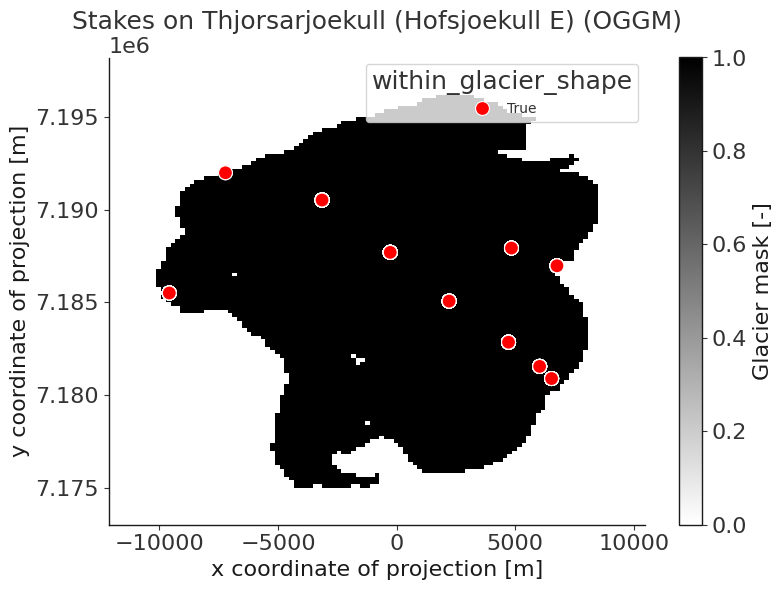

In [ ]:
# Example:
glacierName = 'Thjorsarjoekull (Hofsjoekull E)'
# stakes
df_stakes_topo_1 = df_stakes_topo.copy()
df_stakes_topo_1 = df_stakes_topo_1[(df_stakes_topo_1['GLACIER'] == glacierName)]
RGIId = df_stakes_topo_1['RGIId'].unique()[0]
print(RGIId)
# open OGGM xr for glacier
# Get oggm data for that RGI grid
ds_oggm = xr.open_dataset(f'{cfg.dataPath + path_OGGM_xrgrids}/{RGIId}.zarr')

# Define the coordinate transformation
transf = pyproj.Transformer.from_proj(
    pyproj.CRS.from_user_input("EPSG:4326"),  # Input CRS (WGS84)
    pyproj.CRS.from_user_input(ds_oggm.pyproj_srs),  # Output CRS from dataset
    always_xy=True)

# Transform all coordinates in the group
lon, lat = df_stakes_topo_1["POINT_LON"].values, df_stakes_topo_1["POINT_LAT"].values
x_stake, y_stake = transf.transform(lon, lat)
df_stakes_topo_1['x'] = x_stake
df_stakes_topo_1['y'] = y_stake

# plot stakes
plt.figure(figsize=(8, 6))
ds_oggm.glacier_mask.plot(cmap='binary')
sns.scatterplot(df_stakes_topo_1,
                x='x',
                y='y',
                hue='within_glacier_shape',
                palette=['r', 'b'])
plt.title(f'Stakes on {glacierName} (OGGM)')
plt.tight_layout()

In [30]:
# Restrict to within glacier shape
df_stakes_topo = df_stakes_topo[df_stakes_topo['within_glacier_shape'] == True]
df_stakes_topo = df_stakes_topo.drop(columns=['within_glacier_shape'])

# Display rows that have any NaN values
display(df_stakes_topo[df_stakes_topo.isna().any(axis=1)])

# Drop 3 rows where consensus_ice_thickness is NaN
df_stakes_topo_dropped = df_stakes_topo.dropna(subset=['consensus_ice_thickness'])

display(len(df_stakes_topo_dropped[df_stakes_topo_dropped['consensus_ice_thickness'].isna()]))


,POINT_ELEVATION,POINT_LAT,POINT_LON,ID,DATA_MODIFICATION,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,YEAR,RGIId,aspect,slope,topo,consensus_ice_thickness,millan_v,GLACIER
1553,486.0,64.494360,-20.435610,L01,,20011005,20021031,-7.371,annual,2002.0,RGI60-06.00291,224.979505,1.592727,479.944916,NaN,0.000000,Hagafellsjoekull West
4846,486.0,64.494360,-20.435610,L01,,20011005,20020426,1.022,winter,2002.0,RGI60-06.00291,224.979505,1.592727,479.944916,NaN,0.000000,Hagafellsjoekull West
5261,1770.0,64.566674,-17.466664,GL10,Dates filled in according to hydrological year,19961001,19970825,1.200,winter,1997.0,RGI60-06.00473,210.976976,0.757997,1751.607300,NaN,26.194727,Sylgjujoekull


0

In [31]:
# Create new POINT_ID column
df_stakes_topo_dropped['POINT_ID'] = (
    df_stakes_topo_dropped['GLACIER'] + '_' + 
    df_stakes_topo_dropped['YEAR'].astype(str) + '_' + 
    df_stakes_topo_dropped['PERIOD'].astype(str) + '_' +
    df_stakes_topo_dropped['ID'].astype(str)
)

df_stakes_topo_dropped = df_stakes_topo_dropped.drop(columns=['ID'])

display(df_stakes_topo_dropped.head(2))

,POINT_ELEVATION,POINT_LAT,POINT_LON,DATA_MODIFICATION,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,YEAR,RGIId,aspect,slope,topo,consensus_ice_thickness,millan_v,GLACIER,POINT_ID
0,1744.39,64.555705,-17.410172,,20060925,20071010,1.785833,annual,2007.0,RGI60-06.00475,151.898407,0.876541,1740.480713,488.543335,26.53290,Skeidararjoekull,Skeidararjoekull_2007.0_annual_Gjal28
1,1594.20,64.529965,-17.007155,Dates filled in according to hydrological year,19921001,19930928,3.375500,annual,1993.0,RGI60-06.00477,10.779899,1.033374,1573.148926,589.661133,40.94659,Dyngjujoekull,Dyngjujoekull_1993.0_annual_D09


In [45]:
# Check for NaN
display(df_stakes_topo_dropped[df_stakes_topo_dropped.isna().any(axis=1)])

,POINT_ELEVATION,POINT_LAT,POINT_LON,DATA_MODIFICATION,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,YEAR,RGIId,aspect,slope,topo,consensus_ice_thickness,millan_v,GLACIER,POINT_ID


In [ ]:
output_path = (cfg.dataPath + path_PMB_WGMS_csv + 'ICE_dataset_all_oggm.csv')
df_stakes_topo_dropped.to_csv(output_path, index=False)

,POINT_ELEVATION,POINT_LAT,POINT_LON,DATA_MODIFICATION,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,YEAR,RGIId,aspect,slope,topo,consensus_ice_thickness,millan_v,GLACIER,POINT_ID
